## 0. Execute Once - Load Dataset From Kaggle

### Set up the notebook
- **Create new API Token** under Kaggle profile
- Upload downloaded kaggle.json file to the designated folder on Google Drive

In [ ]:
# ! pip install kaggle

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
# mount Google Drive to Google Colab notebook
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

Mounted at /content/gdrive


### Config Kaggle

In [ ]:
# set the Kaggle configuration path to kaggle.json
import os
os.environ['KAGGLE_CONFIG_DIR'] = "/content/gdrive/MyDrive/deep_learning"

In [ ]:
# change the working directory
%cd /content/gdrive/MyDrive/deep_learning/data

/content/gdrive/MyDrive/deep_learning/data


### Download Dataset

Go to Kaggle datasets Dashboard and click on `Copy API Command`.

Note: The dataset is downloaded as a zip file. We use a keyword `--unzip` used to instantly unzip the file after download and delete the zip file.

In [ ]:
!kaggle datasets download -d cookiefinder/tomato-disease-multiple-sources

tomato-disease-multiple-sources.zip: Skipping, found more recently modified local copy (use --force to force download)


In [ ]:
# check the file using 'ls' command
%ls

tomato-disease-multiple-sources.zip


In [ ]:
# [Alternative] download zipped datasets and manually unzip using python library
import zipfile

with zipfile.ZipFile('tomato-disease-multiple-sources.zip','r') as zip_ref:
  zip_ref.extractall('./')

In [ ]:
# audit: make sure we have 25,851 images in train and 6684 images in valid
train_len, test_len = 0, 0
TRAIN_DATA_PATH = '/content/gdrive/MyDrive/deep_learning/data/train'
VALID_DATA_PATH = '/content/gdrive/MyDrive/deep_learning/data/valid'

for f in os.listdir(TRAIN_DATA_PATH):
  train_len += len(os.listdir(os.path.join(TRAIN_DATA_PATH, f)))
  test_len += len(os.listdir(os.path.join(VALID_DATA_PATH, f)))

assert train_len == 25851, "Missing images in training set. It should include 25,851 images"
assert test_len == 6684, "Missing images in valid set. It should include 6,684 images"
print(train_len); print(test_len)

25851
6684


## 1. Set-up

In [ ]:
# # mount Google Drive to Google Colab notebook
# from google.colab import drive
# drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
# data manipulation
import numpy as np
import pandas as pd

# image processing
import cv2
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
sns.set_style('darkgrid')

# data preprocessing and modeling
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Activation, Dropout, BatchNormalization
from tensorflow.keras.models import Model, load_model, Sequential
from tensorflow.python.keras.callbacks import EarlyStopping, ModelCheckpoint, LearningRateScheduler

# pre-trained model
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input, decode_predictions

# sklearn utility functions
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

# others
import os, gc, time, pathlib
import tqdm, re, json
import imghdr

# set up random seed
import random
seed = 24
tf.random.set_seed(seed)

# customize printing
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 200)
pd.set_option('max_colwidth', 200)

In [ ]:
# environmental variables
TRAIN_DATA_PATH = '/content/gdrive/MyDrive/deep_learning/data/train'
VALID_DATA_PATH = '/content/gdrive/MyDrive/deep_learning/data/valid'

CLASSES = sorted(os.listdir(TRAIN_DATA_PATH))
NUM_CLASSES = len(CLASSES)

print(CLASSES)
print('{} classes of images'.format(NUM_CLASSES))

['Bacterial_spot', 'Early_blight', 'Late_blight', 'Leaf_Mold', 'Septoria_leaf_spot', 'Spider_mites Two-spotted_spider_mite', 'Target_Spot', 'Tomato_Yellow_Leaf_Curl_Virus', 'Tomato_mosaic_virus', 'healthy', 'powdery_mildew']
11 classes of images


Define utility functions
- training history plot
- confusion matrix

In [ ]:
def plot_training(hist):
  '''
  This function plots training history. (ie training loss vs validation loss)
  '''
  tr_acc = hist.history['accuracy']
  tr_loss = hist.history['loss']
  val_acc = hist.history['val_accuracy']
  val_loss = hist.history['val_loss']
  index_loss = np.argmin(val_loss)
  val_lowest = val_loss[index_loss]
  index_acc = np.argmax(val_acc)
  acc_highest = val_acc[index_acc]

  plt.figure(figsize= (20, 8))
  plt.style.use('fivethirtyeight')
  Epochs = [i+1 for i in range(len(tr_acc))]
  loss_label = f'best epoch= {str(index_loss + 1)}'
  acc_label = f'best epoch= {str(index_acc + 1)}'

  plt.subplot(1, 2, 1)
  plt.plot(Epochs, tr_loss, 'r', label= 'Training loss')
  plt.plot(Epochs, val_loss, 'g', label= 'Validation loss')
  plt.scatter(index_loss + 1, val_lowest, s= 150, c= 'blue', label= loss_label)
  plt.title('Training and Validation Loss')
  plt.xlabel('Epochs')
  plt.ylabel('Loss')
  plt.legend()

  plt.subplot(1, 2, 2)
  plt.plot(Epochs, tr_acc, 'r', label= 'Training Accuracy')
  plt.plot(Epochs, val_acc, 'g', label= 'Validation Accuracy')
  plt.scatter(index_acc + 1 , acc_highest, s= 150, c= 'blue', label= acc_label)
  plt.title('Training and Validation Accuracy')
  plt.xlabel('Epochs')
  plt.ylabel('Accuracy')
  plt.legend()
  plt.tight_layout
  plt.show()

In [ ]:
# source: https://github.com/DTrimarchi10/confusion_matrix
def make_confusion_matrix(cf, group_names=None,categories='auto', count=True,percent=False,cbar=True, 
                          xyticks=True,xyplotlabels=True,sum_stats=True,figsize=None,
                          cmap='Blues',title=None):
    '''
    This function will make a pretty plot of an sklearn Confusion Matrix cm using a Seaborn heatmap visualization.
    Arguments
    ---------
    cf:            confusion matrix to be passed in
    group_names:   List of strings that represent the labels row by row to be shown in each square.
    categories:    List of strings containing the categories to be displayed on the x,y axis. Default is 'auto'
    count:         If True, show the raw number in the confusion matrix. Default is True.
    normalize:     If True, show the proportions for each category. Default is True.
    cbar:          If True, show the color bar. The cbar values are based off the values in the confusion matrix.
                   Default is True.
    xyticks:       If True, show x and y ticks. Default is True.
    xyplotlabels:  If True, show 'True Label' and 'Predicted Label' on the figure. Default is True.
    sum_stats:     If True, display summary statistics below the figure. Default is True.
    figsize:       Tuple representing the figure size. Default will be the matplotlib rcParams value.
    cmap:          Colormap of the values displayed from matplotlib.pyplot.cm. Default is 'Blues'
                   See http://matplotlib.org/examples/color/colormaps_reference.html
                   
    title:         Title for the heatmap. Default is None.
    '''


    # CODE TO GENERATE TEXT INSIDE EACH SQUARE
    blanks = ['' for i in range(cf.size)]

    if group_names and len(group_names)==cf.size:
        group_labels = ["{}\n".format(value) for value in group_names]
    else:
        group_labels = blanks

    if count:
        group_counts = ["{0:0.0f}\n".format(value) for value in cf.flatten()]
    else:
        group_counts = blanks

    if percent:
        group_percentages = ["{0:.2%}".format(value) for value in cf.flatten()/np.sum(cf)]
    else:
        group_percentages = blanks

    box_labels = [f"{v1}{v2}{v3}".strip() for v1, v2, v3 in zip(group_labels,group_counts,group_percentages)]
    box_labels = np.asarray(box_labels).reshape(cf.shape[0],cf.shape[1])


    # CODE TO GENERATE SUMMARY STATISTICS & TEXT FOR SUMMARY STATS
    if sum_stats:
        #Accuracy is sum of diagonal divided by total observations
        accuracy  = np.trace(cf) / float(np.sum(cf))

        #if it is a binary confusion matrix, show some more stats
        if len(cf)==2:
            #Metrics for Binary Confusion Matrices
            precision = cf[1,1] / sum(cf[:,1])
            recall    = cf[1,1] / sum(cf[1,:])
            f1_score  = 2*precision*recall / (precision + recall)
            stats_text = "\n\nAccuracy={:0.3f}\nPrecision={:0.3f}\nRecall={:0.3f}\nF1 Score={:0.3f}".format(
                accuracy,precision,recall,f1_score)
        else:
            stats_text = "\n\nAccuracy={:0.3f}".format(accuracy)
    else:
        stats_text = ""


    # SET FIGURE PARAMETERS ACCORDING TO OTHER ARGUMENTS
    if figsize==None:
        #Get default figure size if not set
        figsize = plt.rcParams.get('figure.figsize')

    if xyticks==False:
        #Do not show categories if xyticks is False
        categories=False


    # MAKE THE HEATMAP VISUALIZATION
    plt.figure(figsize=figsize)
    sns.heatmap(cf,annot=box_labels,fmt="",cmap=cmap,cbar=cbar,xticklabels=categories,yticklabels=categories)

    if xyplotlabels:
        plt.ylabel('True label')
        plt.xlabel('Predicted label' + stats_text)
    else:
        plt.xlabel(stats_text)
    
    if title:
        plt.title(title)

In [ ]:
def error_analysis(model, test_data, class_names):
  plt.figure(figsize=(18,12))
  for image_batch,label_batch in test_data.take(4):
      predictions = model.predict(image_batch)
      predictions = np.argmax(predictions, axis=-1)
      for i in range(0,len(predictions) if len(predictions)<12 else 12):
          plt.subplot(3,4,i+1)
          plt.imshow(image_batch[i].numpy().astype("uint32"))
          true_class = class_names[np.argmax(label_batch[i])]
          predict_class = class_names[predictions[i]]
          title = f"""True: {true_class}\n Predict: {predict_class}"""
          plt.title(title, color='g' if true_class==predict_class else 'r')
          plt.axis("off")

## 2. Load Data and Data Cleaning

TensorFlow has some strictness when dealing with image formats. Some times your data set may even run well with, for instance Torch but will generate a format error with Tf. Nonetheless, it is best practice to always carryout preprocessing on the images to ensure a robust, safe and standard model.

*Reference*:
- [Unknown image file format. One of JPEG, PNG, GIF, BMP required](https://stackoverflow.com/questions/68191448/unknown-image-file-format-one-of-jpeg-png-gif-bmp-required)

In [ ]:
def image_quality_check(image_dir):
  '''
  This functions checks whether file formats accepted by Tensorflow ( JPEG, PNG, GIF, BMP), or may be corrupted.
  '''
  from pathlib import Path
  import imghdr

  image_extensions = ['.jpg', '.png', '.jpeg', '.PNG', '.JPG', '.JPEG']
  img_type_accepted_by_tf = ["bmp", "gif", "jpeg", "png"]
  bad_images = []

  for filepath in Path(image_dir).rglob("*"):
    if filepath.suffix.lower() in image_extensions:
        img_type = imghdr.what(filepath)
        if img_type is None:
            print(f"{filepath} is not an image")
            bad_images.append(filepath)
        elif img_type not in img_type_accepted_by_tf:
            print(f"{filepath} is a {img_type}, not accepted by TensorFlow")
            bad_images.append(filepath)
  return bad_images

In [ ]:
def image_quality_check2(image_dir):
  '''
  This function captures corrupted image files (jpg and png) that may missed by first QA function.
  '''
  import os, glob

  # validate directory
  assert os.path.exists(image_dir), "Error: directory does not exist"

  bad_images = []
  classes = sorted([c for c in os.listdir(image_dir) if os.path.isdir(os.path.join(image_dir, c))])

  def is_valid_jpg(jpg_file):
    with open(jpg_file, 'rb') as f:
      f.seek(-2,2)
      buf = f.read()
      return buf == b'\xff\xd9'

  def is_valid_png(png_file):
    with open(png_file, 'rb') as f:
      f.seek(-2,2)
      but = f.read()
      return but == b'\x60\x82'

  for f_class in classes:
    class_path = os.path.join(image_dir, f_class)
    file_list = os.listdir(class_path)
    desc = f'{f_class:23s}'
    for file in tqdm.tqdm(file_list, ncols=110, desc=desc, unit='file', colour='blue'):
      fpath = os.path.join(class_path, file)
      index = file.rfind('.')
      if file[index:] in ['.jpg', '.jpeg','.JPG', '.JPEG']:
        if not is_valid_jpg(fpath):
          print(fpath)
          bad_images.append(fpath)
      
      if file[index:] in ['.png', '.PNG']:
        if not is_valid_png(fpath):
          print(fpath)
          bad_images.append(fpath)

  return bad_images

In [ ]:
def image_quality_check3(image_dir):
  '''
  This function focuses on identifying corrupted png images that may be missed by the QA1 and QA2.
  '''
  assert os.path.exists(image_dir), "Error: directory does not exist"

  bad_images = []
  classes = sorted([c for c in os.listdir(image_dir) if os.path.isdir(os.path.join(image_dir, c))])

  for f_class in classes:
    class_path = os.path.join(image_dir, f_class)
    file_list = os.listdir(class_path)
    desc = f'{f_class:23s}'
    for file in tqdm.tqdm(file_list, ncols=110, desc=desc, unit='file', colour='blue'):
      fpath = os.path.join(class_path, file)
      index = file.rfind('.')
      if file[index:] in ['.png', '.PNG']:
        try:
          image = tf.io.read_file(fpath)
          image = tf.image.decode_png(image, channels=3)
        except:
          bad_images.append(fpath)
          print('defective image file: ', fpath)
  return bad_images

In [ ]:
# check image quality
%time
print("-"*20, "check training set image quality.","-"*20)
bad_images_train = image_quality_check(TRAIN_DATA_PATH)
print("-"*20, "check test and validation set image quality.","-"*20)
bad_images_val_test = image_quality_check(VALID_DATA_PATH)

CPU times: user 4 µs, sys: 0 ns, total: 4 µs
Wall time: 7.87 µs
-------------------- check training set image quality. --------------------
/content/gdrive/MyDrive/deep_learning/data/train/Early_blight/220px-Alternaria_solani_-_leaf_lesions.jpg is not an image
/content/gdrive/MyDrive/deep_learning/data/train/Early_blight/EB_(976).jpg is not an image
/content/gdrive/MyDrive/deep_learning/data/train/Early_blight/early-blight-tomato-causal-agents-260nw-1746486380.jpg is not an image
/content/gdrive/MyDrive/deep_learning/data/train/Leaf_Mold/607-155-1.jpg is not an image
/content/gdrive/MyDrive/deep_learning/data/train/Leaf_Mold/BM_(6).jpg is not an image
/content/gdrive/MyDrive/deep_learning/data/train/Leaf_Mold/BM_(7).jpg is not an image
/content/gdrive/MyDrive/deep_learning/data/train/Leaf_Mold/BM_(975).jpg is not an image
/content/gdrive/MyDrive/deep_learning/data/train/Leaf_Mold/BM_(976).jpg is not an image
/content/gdrive/MyDrive/deep_learning/data/train/Leaf_Mold/BM_(98).jpg is not 

In [ ]:
# check image quality 2
%time
print("-"*20, "check training set image quality.","-"*20)
bad_images_train2 = image_quality_check2(TRAIN_DATA_PATH)
print("-"*20, "check test and validation set image quality.","-"*20)
bad_images_val_test2 = image_quality_check2(VALID_DATA_PATH)

CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 5.96 µs
-------------------- check training set image quality. --------------------


Bacterial_spot         :  89%|███████████████████████████████████▊    | 2526/2826 [00:01<00:00, 1493.57file/s]

/content/gdrive/MyDrive/deep_learning/data/train/Bacterial_spot/bacterialspotontomatoXant.JPG


Early_blight           : 100%|████████████████████████████████████████| 2455/2455 [00:01<00:00, 1477.91file/s]

/content/gdrive/MyDrive/deep_learning/data/train/Early_blight/earlyblighthttp___wwwlsuagcenter.jpg



healthy                :  57%|██████████████████████▋                 | 1730/3051 [00:01<00:00, 1501.96file/s]

/content/gdrive/MyDrive/deep_learning/data/train/healthy/A-Healthy-leaves-of-tomato-plants-and-B-Leaves-of-tomato-plants-inoculated-with.png


healthy                :  82%|████████████████████████████████▊       | 2507/3051 [00:01<00:00, 1495.24file/s]

/content/gdrive/MyDrive/deep_learning/data/train/healthy/edible-tomato-leaves.jpg


powdery_mildew         : 100%|████████████████████████████████████████| 1004/1004 [00:00<00:00, 1569.52file/s]


-------------------- check test and validation set image quality. --------------------


Leaf_Mold              :  75%|███████████████████████████████▍          | 553/739 [00:00<00:00, 1385.36file/s]

/content/gdrive/MyDrive/deep_learning/data/valid/Leaf_Mold/BM_(9).jpg


healthy                :  36%|███████████████▏                          | 292/806 [00:00<00:00, 1473.62file/s]

/content/gdrive/MyDrive/deep_learning/data/valid/healthy/2013-08-20-05.jpg


healthy                :  92%|██████████████████████████████████████▍   | 738/806 [00:00<00:00, 1459.75file/s]

/content/gdrive/MyDrive/deep_learning/data/valid/healthy/HL_(336).png


powdery_mildew         : 100%|██████████████████████████████████████████| 252/252 [00:00<00:00, 1575.37file/s]


In [ ]:
# check image quality 3
%time
print("-"*20, "check training set image quality.","-"*20)
bad_images_train3 = image_quality_check3(TRAIN_DATA_PATH)
print("-"*20, "check test and validation set image quality.","-"*20)
bad_images_val_test3 = image_quality_check3(VALID_DATA_PATH)

CPU times: user 2 µs, sys: 1 µs, total: 3 µs
Wall time: 5.96 µs
-------------------- check training set image quality. --------------------


powdery_mildew         : 100%|██████████████████████████████████████| 1004/1004 [00:00<00:00, 527572.19file/s]


-------------------- check test and validation set image quality. --------------------


healthy                :  46%|███████████████████▎                      | 370/806 [00:00<00:00, 3610.46file/s]

defective image file:  /content/gdrive/MyDrive/deep_learning/data/valid/healthy/HL_(336).png


powdery_mildew         : 100%|████████████████████████████████████████| 252/252 [00:00<00:00, 559536.58file/s]


In [ ]:
move_bad_images = True
bad_images = set(bad_images_train + bad_images_val_test + bad_images_train2 + bad_images_val_test2 + bad_images_train3 + bad_images_val_test3)
bad_images

if move_bad_images:
  for link in bad_images:
    if os.path.exists(link):
      os.remove(str(link))

print('Move {} images with bad quality.'.format(len(bad_images)))

{'/content/gdrive/MyDrive/deep_learning/data/train/Bacterial_spot/bacterialspotontomatoXant.JPG',
 PosixPath('/content/gdrive/MyDrive/deep_learning/data/train/Early_blight/220px-Alternaria_solani_-_leaf_lesions.jpg'),
 PosixPath('/content/gdrive/MyDrive/deep_learning/data/train/Early_blight/EB_(976).jpg'),
 PosixPath('/content/gdrive/MyDrive/deep_learning/data/train/Early_blight/early-blight-tomato-causal-agents-260nw-1746486380.jpg'),
 '/content/gdrive/MyDrive/deep_learning/data/train/Early_blight/earlyblighthttp___wwwlsuagcenter.jpg',
 PosixPath('/content/gdrive/MyDrive/deep_learning/data/train/Leaf_Mold/607-155-1.jpg'),
 PosixPath('/content/gdrive/MyDrive/deep_learning/data/train/Leaf_Mold/BM_(6).jpg'),
 PosixPath('/content/gdrive/MyDrive/deep_learning/data/train/Leaf_Mold/BM_(7).jpg'),
 PosixPath('/content/gdrive/MyDrive/deep_learning/data/train/Leaf_Mold/BM_(975).jpg'),
 PosixPath('/content/gdrive/MyDrive/deep_learning/data/train/Leaf_Mold/BM_(976).jpg'),
 PosixPath('/content/gdri

Move 25 images with bad quality.


In [ ]:
# check number of images remained
train_len, test_len = 0, 0
for f in os.listdir(TRAIN_DATA_PATH):
  train_len += len(os.listdir(os.path.join(TRAIN_DATA_PATH, f)))
  test_len += len(os.listdir(os.path.join(VALID_DATA_PATH, f)))
print(train_len);print(test_len)

25787
6677


Copy files from a mounted Google Drive to a local Google Colab session

In [ ]:
#!rm /content/data -r
!mkdir /content/data

In [ ]:
!cp -r /content/gdrive/MyDrive/deep_learning/data/train /content/data
!cp -r /content/gdrive/MyDrive/deep_learning/data/valid /content/data

In [ ]:
# update file path
TRAIN_DATA_PATH = '/content/data/train'
VALID_DATA_PATH = '/content/data/valid'

In [ ]:
# check number of images remained
train_len, test_len = 0, 0
for f in os.listdir(TRAIN_DATA_PATH):
  train_len += len(os.listdir(os.path.join(TRAIN_DATA_PATH, f)))
  test_len += len(os.listdir(os.path.join(VALID_DATA_PATH, f)))
print(train_len);print(test_len)

25787
6677


#### Load Data

We will use high-level Keras preprocessing utilities (such as `tf.keras.utils.image_dataset_from_directory`) and layers (such as `tf.keras.layers.Rescaling`) to read a directory of images on disk. 
  - `image_dataset_from_directory` returns a `tf.data.Dataset` object, a tuple `(images, labels)`, where `images` has shape  is `(batch_size, image_size[0], image_size[1], num_channels)`. 
  - supported image formats: jpeg, png, bmp, gif

*Reference*:
- [tf.keras.utils.image_dataset_from_directory](https://www.tensorflow.org/api_docs/python/tf/keras/utils/image_dataset_from_directory)

In [ ]:
IMG_HEIGHT, IMG_WIDTH = 224, 224   # ResNet50 works best with input images of 224 x 224
BATCH_SIZE = 32
LABEL_MODE = 'categorical'  # labels: one-hot encoded, a float32 tensor of shape (batch_size, num_classes). loss: categorical_crossentropy
COLOR_MODE = 'rgb'
VALID_TEST_RATIO = 0.5
AUTOTUNE = tf.data.AUTOTUNE

In [ ]:
# training set - expect 25,851 (25,787) images
train_ds = keras.utils.image_dataset_from_directory(
        directory=TRAIN_DATA_PATH,
        batch_size = BATCH_SIZE, 
        image_size = (IMG_HEIGHT, IMG_WIDTH), 
        label_mode=LABEL_MODE,
        color_mode=COLOR_MODE,
        shuffle=True,
        seed = seed
        )

Found 25787 files belonging to 11 classes.


In [ ]:
# validation and test sets - expect 6684 (6,677) images
val_test_ds = keras.utils.image_dataset_from_directory(
        directory=VALID_DATA_PATH,
        batch_size = BATCH_SIZE, 
        image_size = (IMG_HEIGHT, IMG_WIDTH), 
        label_mode=LABEL_MODE,
        color_mode=COLOR_MODE,
        shuffle=True,
        seed = seed,
        validation_split = VALID_TEST_RATIO, 
        subset = 'both',
        )

valid_ds = val_test_ds[0]
test_ds = val_test_ds[1]

Found 6677 files belonging to 11 classes.
Using 3339 files for training.
Using 3338 files for validation.


In [ ]:
# audit - make sure validation and test sets are approximately follow same distribution
assert((train_ds.class_names == valid_ds.class_names) and (train_ds.class_names == test_ds.class_names)), 'Labels in training, validation, and test does not match'

In [ ]:
CLASS_NAMES = test_ds.class_names
CLASS_NAMES

['Bacterial_spot',
 'Early_blight',
 'Late_blight',
 'Leaf_Mold',
 'Septoria_leaf_spot',
 'Spider_mites Two-spotted_spider_mite',
 'Target_Spot',
 'Tomato_Yellow_Leaf_Curl_Virus',
 'Tomato_mosaic_virus',
 'healthy',
 'powdery_mildew']

In [ ]:
print('train dataset size: ' + str(train_ds.cardinality().numpy()))
print('valid dataset size: ' + str(valid_ds.cardinality().numpy()))
print('test dataset size: ' + str(test_ds.cardinality().numpy()))

train dataset size: 806
valid dataset size: 105
test dataset size: 105


## 3. Data Preprocessing

#### Data Augmentation

Note: Data augmentation is inactive at test time so input images will only be augmented during calls to `Model.fit` during training (not `Model.evaluate` or `Model.predict`).

1) Using Keras preprocessing layers, such as`tf.keras.layers.RandomCrop`,`tf.keras.layers.RandomFlip`, `tf.keras.layers.RandomTranslation`, `tf.keras.layers.RandomRotation`, `tf.keras.layers.RandomZoom`, `tf.keras.layers.RandomHeight`, `tf.keras.layers.RandomWidth`, `tf.keras.layers.RandomContrast`

2) Using `tf.image` methods, such as `tf.image.flip_left_right`, `tf.image.rgb_to_grayscale`, `tf.image.adjust_brightness`, `tf.image.central_crop`, and `tf.image.stateless_random*`.

*Reference*:
- [keras documentation: data_augmentation](https://www.tensorflow.org/tutorials/images/data_augmentation)
- [image classification](https://www.tensorflow.org/tutorials/images/classification#setup)

In [ ]:
data_augmentation = keras.Sequential(
    [
      # make model more tolerate to variations in position 
      layers.RandomFlip("horizontal", input_shape=(IMG_HEIGHT, IMG_WIDTH, 3), seed=seed),
      layers.RandomRotation(0.1, seed = seed),
      layers.RandomZoom(0.1, seed = seed),
     
      # make model more tolerate to different lighting conditions 
      layers.RandomContrast(0.15, seed = seed),
    ], name = 'data_augmentation'
)

#### Data Preprocessing for Pre-trained Model

Each Keras Application expects a specific kind of input preprocessing. For ResNet, call `tf.keras.applications.resnet.preprocess_input` on your inputs before passing them to the model. `resnet.preprocess_input` will convert the input images from RGB to BGR, then will zero-center each color channel with respect to the ImageNet dataset, without scaling.

Some pre-trained models use images with values ranging from 0 to 1. Others from -1 to +1. Others use the "caffe" style, that is not normalized, but is centered.

From the [source](https://github.com/keras-team/keras/blob/master/keras/applications/imagenet_utils.py#L72) code, Resnet is using the caffe style.

*Reference*:
- [working with preprocessing layers](https://www.tensorflow.org/guide/keras/preprocessing_layers)
- [apply the preprocessing layers to the datasets](https://www.tensorflow.org/tutorials/images/data_augmentation#apply_the_preprocessing_layers_to_the_datasets)
- [tf.keras.applications.resnet50.preprocess_input](https://www.tensorflow.org/api_docs/python/tf/keras/applications/resnet50/preprocess_input)
- [Better performance with the tf.data API](https://www.tensorflow.org/guide/data_performance)
- [how to apply `preprocessing_input` to `tf.data.Dataset`](https://stackoverflow.com/questions/74818306/issues-with-using-tensorflows-preprocessing-function-for-inceptionv3)

In [ ]:
augment = True

if augment:
  train_ds = train_ds.map(lambda x, y: (data_augmentation(x, training=True), y))

Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


In [ ]:
def preprocess(images, labels):
  return preprocess_input(images), labels

train_ds = train_ds.map(preprocess)
valid_ds = valid_ds.map(preprocess)
test_ds = test_ds.map(preprocess)

## 4. Pre-trained Model as Feature Extractor

**Set BatchNorm training = True even when I freeze pretrained layers from base model**:

Assume you are building a Computer Vision model but you don’t have enough data, so you decide to use one of the pre-trained CNNs of Keras and fine-tune it. Unfortunately, by doing so you get no guarantees that the mean and variance of your new dataset inside the BN layers will be similar to the ones of the original dataset. Remember that at the moment, during training your network will always use the mini-batch statistics either the BN layer is frozen or not; also during inference you will use the previously learned statistics of the frozen BN layers (ie. imagenet). As a result, if you fine-tune the top layers, their weights will be adjusted to the mean/variance of the new dataset. Nevertheless, during inference they will receive data which are scaled differently because the mean/variance of the original dataset will be used.

*Reference*:
- [datumbox - the batch normalization layer of keras is broken](http://blog.datumbox.com/the-batch-normalization-layer-of-keras-is-broken/)
- [stackoverflow - massive overfitting duruing resnet50 transfer learning](https://stackoverflow.com/questions/50364706/massive-overfit-during-resnet50-transfer-learning)
- [github threads - Change BN layer to use moving mean/var if frozen](https://github.com/keras-team/keras/pull/9965)
- [ResNet50](https://www.tensorflow.org/api_docs/python/tf/keras/applications/resnet50/ResNet50)
- [Sanity Check Before Running the Neural Networkk](https://cs231n.github.io/neural-networks-3/#sanitycheck)

#### Create Model Architecture

In [ ]:
params = {
          'RANDOM_STATE': seed,
          'TRAINABLE': False,
          'DENSE_ACTIVATION':'relu',
          'DROPOUT_RATE':0.125,
          'LEARNING_RATE':5e-4,
          'LEARNING_RATE_DECAY':False,
          'CHECKPOINT':True,
          'EPOCHS':50,
}

Load pre-trained model

In [ ]:
input_tensor = keras.Input(shape=(IMG_HEIGHT, IMG_WIDTH, 3))

# load pre-trained model and remove top classifier head
base_model = ResNet50(weights='imagenet', 
                     include_top=False, 
                     input_tensor = input_tensor
                    )

x = base_model.output

In [ ]:
# We 'freeze' all layers except for the last block of the ResNet50.
for layer in base_model.layers:
    layer.trainable = params['TRAINABLE']

In [ ]:
# un-freeze the BatchNorm layers
for layer in base_model.layers:
  if "BatchNormalization" in layer.__class__.__name__:
      layer.trainable = True

In [ ]:
for i, layer in enumerate(base_model.layers):
  print(i, layer.name, "-", layer.trainable)

0 input_2 - False
1 conv1_pad - False
2 conv1_conv - False
3 conv1_bn - True
4 conv1_relu - False
5 pool1_pad - False
6 pool1_pool - False
7 conv2_block1_1_conv - False
8 conv2_block1_1_bn - True
9 conv2_block1_1_relu - False
10 conv2_block1_2_conv - False
11 conv2_block1_2_bn - True
12 conv2_block1_2_relu - False
13 conv2_block1_0_conv - False
14 conv2_block1_3_conv - False
15 conv2_block1_0_bn - True
16 conv2_block1_3_bn - True
17 conv2_block1_add - False
18 conv2_block1_out - False
19 conv2_block2_1_conv - False
20 conv2_block2_1_bn - True
21 conv2_block2_1_relu - False
22 conv2_block2_2_conv - False
23 conv2_block2_2_bn - True
24 conv2_block2_2_relu - False
25 conv2_block2_3_conv - False
26 conv2_block2_3_bn - True
27 conv2_block2_add - False
28 conv2_block2_out - False
29 conv2_block3_1_conv - False
30 conv2_block3_1_bn - True
31 conv2_block3_1_relu - False
32 conv2_block3_2_conv - False
33 conv2_block3_2_bn - True
34 conv2_block3_2_relu - False
35 conv2_block3_3_conv - False
36 c

In [ ]:
x = layers.Flatten()(x)
x = layers.Dense(128, activation=params['DENSE_ACTIVATION'])(x) 
x = layers.Dropout(rate=params['DROPOUT_RATE'])(x)
outputs = keras.layers.Dense(NUM_CLASSES, activation='softmax')(x)
model = keras.Model(inputs=input_tensor, outputs=outputs)

model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_2[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                              

#### Compile Model

In [ ]:
optimizer = keras.optimizers.Adam(learning_rate=params['LEARNING_RATE']) 
loss = keras.losses.CategoricalCrossentropy(from_logits=False)

model.compile(optimizer=optimizer,
              loss=loss,
              metrics=["accuracy"]
              )

#### Train Model

In [ ]:
# early stopping 
early_stopping = EarlyStopping(
    monitor='val_loss', 
    mode='min',
    restore_best_weights=True,
    patience=7, 
    verbose=1
)

# check point - save best model
check_point = ModelCheckpoint(filepath='../model/resnet50_best_1.hdf5',
                                          monitor='val_loss',
                                          mode='min',
                                          save_best_only=True
                                          )


# learning rate schedule
lr_start = 0.01

def exponential_decay(lr0, s):
    def exponential_decay_fn(epoch):
        return lr0 * 0.1 **(epoch / s)
    return exponential_decay_fn

exponential_decay_fn = exponential_decay(lr_start, params['EPOCHS'])
lr_scheduler = LearningRateScheduler(exponential_decay_fn)

In [ ]:
callbacks = [early_stopping]

if params['CHECKPOINT']:
  callbacks.append(check_point)
if params['LEARNING_RATE_DECAY']:
  callbacks.append(lr_scheduler)

callbacks

In [ ]:
history = model.fit(
    train_ds,
    validation_data = valid_ds,
    epochs = params['EPOCHS'],
    callbacks = callbacks
)

Epoch 1/50
806/806 [==============================] - 126s 120ms/step - loss: 1.0981 - accuracy: 0.6679 - val_loss: 0.5901 - val_accuracy: 0.8248
Epoch 2/50
806/806 [==============================] - 96s 119ms/step - loss: 0.5755 - accuracy: 0.8003 - val_loss: 0.4854 - val_accuracy: 0.8565
Epoch 3/50
806/806 [==============================] - 97s 119ms/step - loss: 0.4784 - accuracy: 0.8300 - val_loss: 0.3538 - val_accuracy: 0.8862
Epoch 4/50
806/806 [==============================] - 96s 118ms/step - loss: 0.3891 - accuracy: 0.8600 - val_loss: 0.3770 - val_accuracy: 0.8913
Epoch 5/50
806/806 [==============================] - 97s 120ms/step - loss: 0.3459 - accuracy: 0.8773 - val_loss: 0.3294 - val_accuracy: 0.8967
Epoch 6/50
806/806 [==============================] - 96s 119ms/step - loss: 0.3058 - accuracy: 0.8931 - val_loss: 0.2904 - val_accuracy: 0.9185
Epoch 7/50
806/806 [==============================] - 95s 117ms/step - loss: 0.2715 - accuracy: 0.9039 - val_loss: 0.2959 - val_a

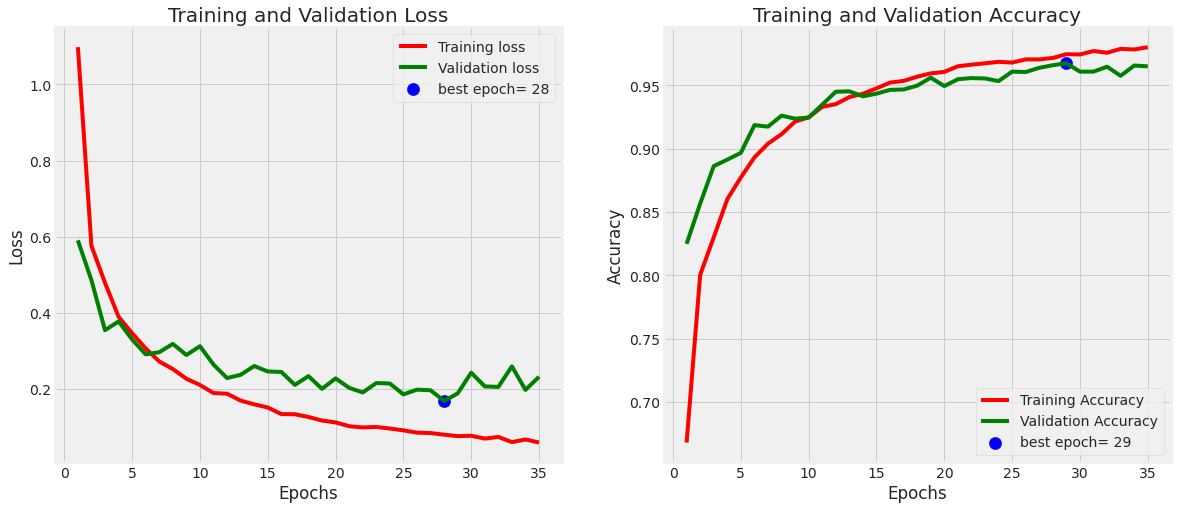

In [ ]:
plot_training(history)

In [ ]:
test_loss, test_accuracy = model.evaluate(test_ds)

print("test loss: {} and test accuracy: {}".format(test_loss, test_accuracy))

105/105 [==============================] - 3s 28ms/step - loss: 0.1659 - accuracy: 0.9643
test loss: 0.16590461134910583 and test accuracy: 0.9643499255180359


In [ ]:
train_loss, train_accuracy = model.evaluate(train_ds)
valid_loss, valid_accuracy = model.evaluate(valid_ds)

print("training loss: {} and training accuracy: {}".format(train_loss, train_accuracy))
print("validation loss: {} and validation accuracy: {}".format(valid_loss, valid_accuracy))

105/105 [==============================] - 3s 28ms/step - loss: 0.1680 - accuracy: 0.9659
training loss: 0.01593056321144104 and training accuracy: 0.9941055774688721
validation loss: 0.16795438528060913 and validation accuracy: 0.9658580422401428


In [ ]:
y_true = np.array([])
y_pred = np.array([])
for x, y in test_ds:
    y_true = np.concatenate([y_true, np.argmax(y, axis=-1)], axis=0)
    y_pred = np.concatenate([y_pred, np.argmax(model.predict(x), axis=-1)], axis=0)

1/1 [==============================] - 1s 955ms/step


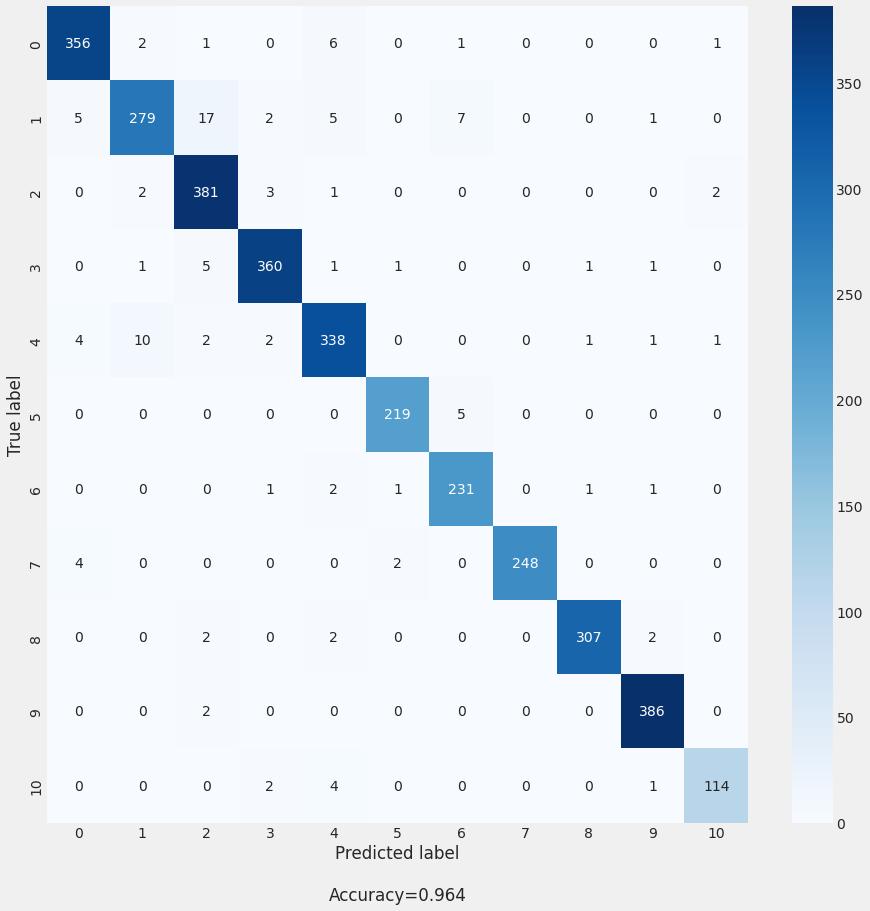

In [ ]:
cf = confusion_matrix(y_true, y_pred)
make_confusion_matrix(cf, CLASS_NAMES ,figsize=(14,14))

#### Follow-up: Load Best Model Back and Generate Additional Performance Metrics
- classification report, includes precision, recall, f1-score by classes
- confusion matrix with target names

To reuse saved model, we need to complete required data prepration steps:
- load images from directory and conduct train/validation/test split to create `tf.data.dataset` 
- conduct data preprocessing either separately or inside of model pipeline (depends on data preprocessing configuration)

Load Best Model

In [ ]:
from keras.models import load_model

In [ ]:
model_fpath = '/content/gdrive/MyDrive/deep_learning/model/resnet_v1/resnet50_best_1_feature-extractor-dataaug.hdf5'

In [ ]:
model = load_model(model_fpath)

In [ ]:
test_loss, test_accuracy = model.evaluate(test_ds)
print("test loss: {} and test accuracy: {}".format(test_loss, test_accuracy))

105/105 [==============================] - 12s 27ms/step - loss: 0.1659 - accuracy: 0.9643
test loss: 0.16591301560401917 and test accuracy: 0.9643499255180359


Generate Classfication Report

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay

In [ ]:
def plt_confusion_mtrx(y_true, y_pred, target_names):
      # classification report
      print(classification_report(y_true, y_pred, target_names=target_names, digits=3))

      # plot confusion matrix
      conf_mtx = confusion_matrix(y_true, y_pred)
      accuracy = np.trace(conf_mtx) / float(np.sum(conf_mtx))
      disp = ConfusionMatrixDisplay(confusion_matrix=conf_mtx, display_labels=target_names)
      fig, ax = plt.subplots(figsize=(10,10)) 

      # beautify the plot
      disp.plot(cmap='Blues',ax=ax)
      plt.grid(False)
      ax.set_title ('Confusion Matrix for Tomato Leaf Disease - Without Normalization')
      ax.set_xlabel('Predicted labels' + "\n\nAccuracy={:0.3f}".format(accuracy))
      ax.set_ylabel('True label')
      ax.set_xticklabels(target_names, rotation=90)

      plt.show()

In [ ]:
target_names = ['Bacterial_spot','Early_blight','Late_blight','Leaf_Mold','Septoria_leaf_spot','Spider_mites Two-spotted_spider_mite',
                'Target_Spot','Tomato_Yellow_Leaf_Curl_Virus','Tomato_mosaic_virus','healthy','powdery_mildew']

In [ ]:
y_true = np.array([])
y_pred = np.array([])
for x, y in test_ds:
    y_true = np.concatenate([y_true, np.argmax(y, axis=-1)], axis=0)
    y_pred = np.concatenate([y_pred, np.argmax(model.predict(x), axis=-1)], axis=0)

1/1 [==============================] - 1s 938ms/step


                                      precision    recall  f1-score   support

                      Bacterial_spot      0.965     0.970     0.967       367
                        Early_blight      0.949     0.883     0.915       316
                         Late_blight      0.929     0.979     0.954       389
                           Leaf_Mold      0.973     0.973     0.973       370
                  Septoria_leaf_spot      0.942     0.942     0.942       359
Spider_mites Two-spotted_spider_mite      0.982     0.978     0.980       224
                         Target_Spot      0.947     0.975     0.960       237
       Tomato_Yellow_Leaf_Curl_Virus      1.000     0.976     0.988       254
                 Tomato_mosaic_virus      0.990     0.981     0.986       313
                             healthy      0.982     0.995     0.988       388
                      powdery_mildew      0.966     0.942     0.954       121

                            accuracy                          

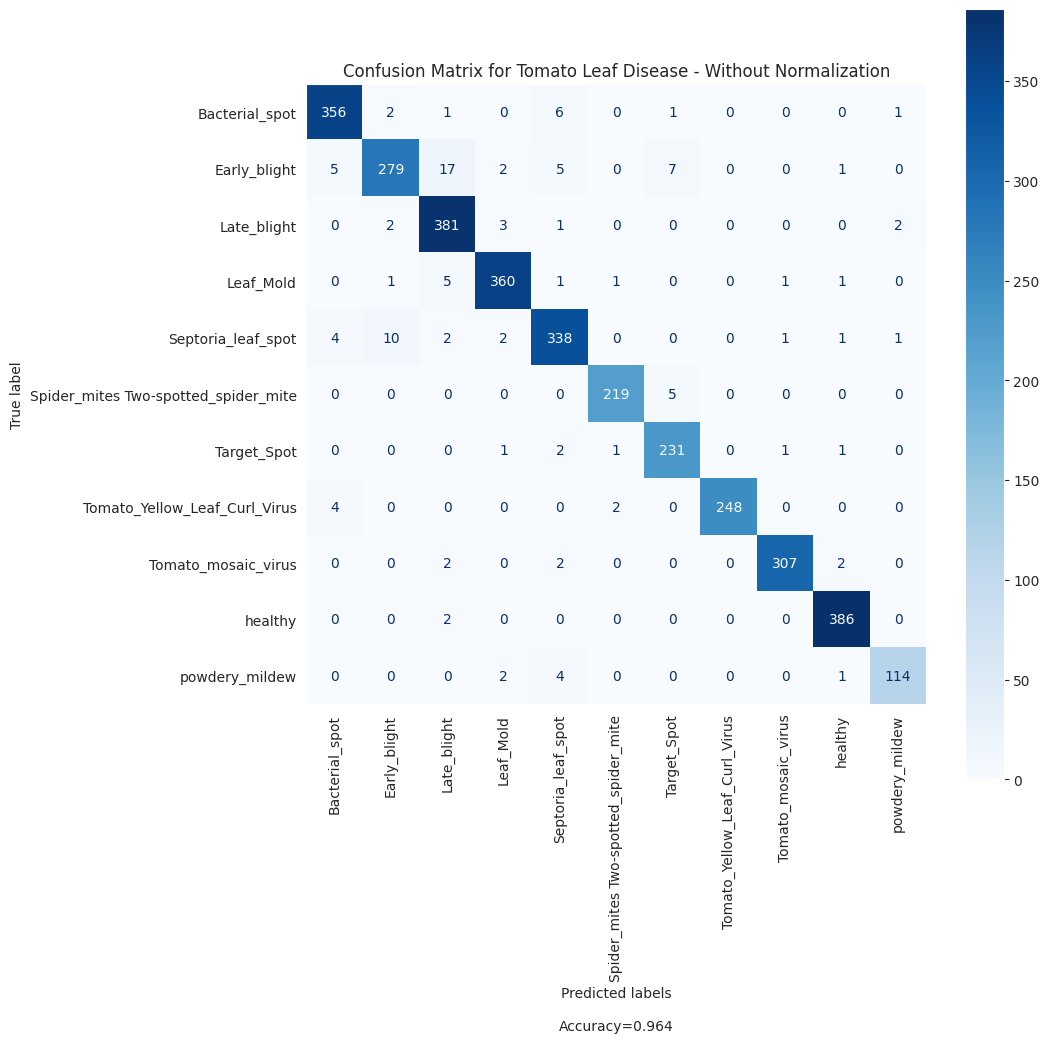

In [ ]:
plt_confusion_mtrx(y_true, y_pred, target_names)